In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import brightway2 as bw
from pathlib import Path

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Basic set-up

In [2]:
PROJECT_NAME = 'iri'
bw.projects.set_current(PROJECT_NAME)

In [3]:
# Databases used:
DBS = {
       'Ecoinvent':            'ecoinvent 3.8 cutoff',
       'Ecoinvent 2050':       'ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)',
       'Digital content':      'Digital Content Consumption',
       'Digital content 2030': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)',
       'Digital content 2040': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2040 (premise v1.2.6)',
       'Digital content 2050': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)'
      }

# LCIA methods:
EF_METHODS = {
              'Climate change':                   ('IPCC 2021', 'climate change: including SLCFs', 'GWP 100a, incl. H and bio CO2'),
              'Acidification':                    ('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (ae) no LT'),
              'Eutrophication, freshwater':       ('EF v3.0 no LT', 'eutrophication: freshwater no LT', 'fraction of nutrients reaching freshwater end compartment (P) no LT'),
              'Eutrophication, marine':           ('EF v3.0 no LT', 'eutrophication: marine no LT', 'fraction of nutrients reaching marine end compartment (N) no LT'),
              'Eutrophication, terrestrial':      ('EF v3.0 no LT', 'eutrophication: terrestrial no LT', 'accumulated exceedance (AE)  no LT'),
              'Photochemical ozone formation':    ('EF v3.0 no LT', 'photochemical ozone formation: human health no LT', 'tropospheric ozone concentration increase no LT'),
              'Particulate matter':               ('EF v3.0 no LT', 'particulate matter formation no LT', 'impact on human health no LT'),
              'Ozone depletion':                  ('EF v3.0 no LT', 'ozone depletion no LT', 'ozone depletion potential (ODP)  no LT'),
              'Ecotoxicity, freshwater':          ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe)  no LT'),
              'Human toxicity, carcinogenic':     ('EF v3.0 no LT', 'human toxicity: carcinogenic no LT', 'comparative toxic unit for human (CTUh)  no LT'),
              'Human toxicity, non-carcinogenic': ('EF v3.0 no LT', 'human toxicity: non-carcinogenic no LT', 'comparative toxic unit for human (CTUh)  no LT'),
              'Ionising radiation':               ('EF v3.0 no LT', 'ionising radiation: human health no LT', 'human exposure efficiency relative to u235 no LT'), 
              'Resource use, fossils':            ('EF v3.0 no LT', 'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT'),
              'Resource use, mineral and metals': ('EF v3.0 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT'),
              'Land use':                         ('EF v3.0 no LT', 'land use no LT', 'soil quality index no LT'),
              'Water use':                        ('EF v3.0 no LT', 'water use no LT', 'user deprivation potential (deprivation-weighted water consumption) no LT')
             }

# Assessed locations
LOCATIONS = {# Regions
             'GLO': 'World', 
             'BR': 'Brazil', 
             'CA': 'Canada',
             'CN': 'China',
             'IN': 'India',
             'RER': 'Europe',
             'US': 'United States',
             # European countries (ordered by electricity carbon footprint):
             'NO': 'Norway',
             'CH': 'Switzerland',
             'FR': 'France',
             'DK': 'Denmark',
             'ES': 'Spain',
             'IT': 'Italy',
             'DE': 'Germany',
             'PL': 'Poland',
             'GB': 'United Kingdom',
             # Other countries
             'ZA': 'South Africa',
             'AU': 'Australia',
             'RU': 'Russia'
             }

In [4]:
# Import personal carrying capacities
EF_PB_LIMITS = pd.read_excel(Path(r"..\data\LCIA_EF30-Carrying-capacities.xlsx"), 'Carrying_capacities', skiprows=1, usecols='A,J:N', index_col=0)
EF_PB_LIMITS

,EF3.0_2020,EF3.0_2030,EF3.0_2040,EF3.0_2050,units
Climate change,500.563828,500.563828,500.563828,500.563828,kg CO2-eq/person/year
Acidification,128.290676,116.979760,108.709272,102.721779,mol H+-eq/person/year
"Eutrophication, freshwater",0.741520,0.676143,0.628340,0.593732,kg P-eq/person/year
"Eutrophication, marine",25.914717,23.629911,21.959273,20.749799,kg N-eq/person/year
"Eutrophication, terrestrial",786.421845,717.085928,666.387836,629.684505,mol N-eq/person/year
Photochemical ozone formation,52.214305,47.610762,44.244674,41.807764,kg NMVOC-eq/person/year
Particulate matter,0.000075,0.000075,0.000075,0.000075,disease incidence/person/year
Ozone depletion,0.069277,0.063169,0.058703,0.055470,kg CFC-11-eq/person/year
"Ecotoxicity, freshwater",16630.272844,15164.042947,14091.942637,13315.786156,CTUe/person/year
"Human toxicity, carcinogenic",0.000139,0.000139,0.000139,0.000139,CTUh/person/year


In [5]:
# IDs used:
USERS = ['Low technology user', 'Medium technology user', 'High technology user']
DIGITAL_CONTENT = ['Web surfing', 'Social media', 'Video streaming', 'Music streaming', 'Video conferencing']
INTERNET_COMPONENTS = ['End-user devices | operation', 'End-user devices | embodied', 
                       'CPE | operation', 'CPE | embodied', 
                       'Access network', 'Core network', 
                       'Data centres | operation', 'Data centres | embodied']
END_USER_DEVICES = ['Smartphone', 'Tablet', 'Laptop', 'Desktop computer', 'TV']

Run functions to perform LCIA and contribution analysis

In [6]:
%run _Functions_for_results_analysis.ipynb

Figures format

In [7]:
# Nature standards:
# - length single column figure: 89 mm
# - length 1.5 column figure: 120-136 mm
# - length 2 columns figure: 183 mm
# - max. height figure : 247 mm

fig_length = {1:   3.50394,    # 1 column
              1.5: 5.35433, # 1.5 columns
              2:   7.20472}    # 2 columns
fig_height = 9.72441 # maxium height
fontsize_title = 9
fontsize_label = 8
fontsize_legend = 8
fontsize_axs = 8

spineline_width = 0.6

# LCA of digital content consumption

In [8]:
EF_LCIA_current = lcia_per_user_and_loc(USERS, LOCATIONS, DBS['Digital content'], EF_METHODS)
EF_PB_current = impacts_contribution_to_PBs(USERS, LOCATIONS, EF_LCIA_current, EF_PB_LIMITS['EF3.0_2020'])

## Carbon footprint

In [9]:
carbon_footprint_loc = {}
for user in EF_LCIA_current:
    carbon_footprint_loc[user] = {}
    for loc in EF_LCIA_current[user]:
        carbon_footprint_loc[user].update({loc: EF_LCIA_current[user][loc]['Climate change']})

carbon_footprint_loc_df = pd.DataFrame(carbon_footprint_loc)
carbon_footprint_loc_df.sort_values('Medium technology user')

,Low technology user,Medium technology user,High technology user
Norway,67.786907,146.306067,205.843974
Switzerland,69.836421,150.470332,210.918467
France,71.395098,153.637302,214.777674
Canada,78.416243,167.903079,232.161672
Denmark,83.601728,178.439107,245.000671
Brazil,84.214266,179.683680,246.517284
United Kingdom,84.775011,180.823019,247.905660
Spain,85.677546,182.656818,250.140291
Europe,89.708174,190.846372,260.119923
Italy,90.102942,191.648474,261.097349


## Share of the personal carrying capacity

In [10]:
EF_PB_low = pd.DataFrame(EF_PB_current['Low technology user'])
EF_PB_medium = pd.DataFrame(EF_PB_current['Medium technology user'])
EF_PB_high = pd.DataFrame(EF_PB_current['High technology user'])

EF_PB_medium

,World,Brazil,Canada,China,India,Europe,United States,Norway,Switzerland,France,Denmark,Spain,Italy,Germany,Poland,United Kingdom,South Africa,Australia,Russia
Climate change,45.833189,35.896257,33.542791,53.862147,65.268385,38.126281,40.820441,29.228254,30.060169,30.692849,35.647623,36.490215,38.286521,41.778775,53.381308,36.123869,55.841550,51.169497,47.040381
Acidification,1.039020,0.841579,0.784473,1.234805,1.408558,0.900708,0.856184,0.711574,0.724601,0.742517,0.800834,0.964154,0.867374,0.816568,1.403993,0.796957,2.159891,1.113059,1.038011
"Eutrophication, freshwater",2.920918,2.369151,2.684775,2.681926,3.873077,2.975803,2.977124,2.326749,2.352612,2.348101,2.699983,2.541683,2.479800,3.610388,4.568790,2.414026,3.919303,5.047514,3.040950
"Eutrophication, marine",1.281524,1.108880,1.053102,1.541206,1.617611,1.125207,1.098771,1.003828,1.013249,1.033199,1.090067,1.187338,1.112884,1.097603,1.369824,1.095955,1.898412,1.324274,1.214120
"Eutrophication, terrestrial",0.317634,0.252744,0.233541,0.410532,0.452476,0.261523,0.251474,0.216062,0.220530,0.225506,0.254310,0.282910,0.258500,0.253924,0.352569,0.252432,0.550279,0.334557,0.292159
Photochemical ozone formation,1.301605,1.010552,0.965754,1.647194,1.810619,1.076942,1.050073,0.888793,0.902823,0.928451,1.017578,1.160060,1.069746,1.032365,1.466013,1.023231,2.218594,1.355650,1.253578
Particulate matter,13.372150,12.558456,9.428074,21.923999,12.384620,9.930923,10.325868,9.198859,9.246395,9.389966,10.016129,10.086237,10.135445,9.786264,10.887049,9.717017,11.914074,10.101232,10.384698
Ozone depletion,0.018430,0.017420,0.016179,0.015185,0.016145,0.017586,0.019224,0.014369,0.014851,0.015774,0.015537,0.017755,0.023169,0.016619,0.016577,0.017944,0.015573,0.016391,0.024628
"Ecotoxicity, freshwater",56.974868,50.059116,48.453724,68.071572,79.019861,50.680889,52.652348,47.656323,48.213066,49.254680,51.911392,51.118039,50.193126,50.943704,57.610196,50.269902,72.209756,55.246287,50.991333
"Human toxicity, carcinogenic",0.118442,0.110332,0.108736,0.123519,0.137291,0.114712,0.115544,0.106835,0.106694,0.108467,0.114393,0.114999,0.112396,0.115193,0.136303,0.111402,0.141493,0.121151,0.113250


In [11]:
def pb_share_fig(user, carbon_footprint, user_pb, fig_name):
    fig, axs = plt.subplot_mosaic([['CF', 'PB', 'CF_legend'],
                                   ['CF', 'PB', 'PB_legend']],
                                   figsize=(fig_length[2]*0.9, fig_height*0.6), 
                                   gridspec_kw={'width_ratios': [0.2, 3, 0.1]})
    
    sns.heatmap(ax=axs['CF'], data=carbon_footprint[[user]].sort_values(user), cmap="Greens", vmin=100, vmax=400, 
                annot=True, fmt='.0f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['CF_legend'])

    df_plot = user_pb.T.sort_values('Climate change')
    sns.heatmap(ax=axs['PB'], data=df_plot, cmap="Blues", vmin=0, vmax=100, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['PB_legend'])
    
    for lab, annot in zip(axs['CF'].get_yticklabels(), axs['CF'].texts):
        text = lab.get_text()
        if text in ['Europe', 'World']:
            # set the properties of the ticklabel
            lab.set_weight('bold')
            # set the properties of the heatmap annot
            #annot.set_weight('bold')  
              
    axs['PB'].set_yticklabels('')
    axs['CF'].set_xticklabels(['Carbon footprint'], rotation = 45, ha="left", fontsize=fontsize_axs)
    axs['PB'].set_xticklabels(list(df_plot.columns), rotation = 45, ha="left", fontsize=fontsize_axs)

    for col in ['CF', 'PB']:
        axs[col].xaxis.tick_top()
        axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
        axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    
    for col in ['CF_legend', 'PB_legend']:
        for spine in axs[col].spines.values():
            spine.set(visible=True, lw=spineline_width, edgecolor="black")
        axs[col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)

    axs['CF_legend'].set_ylabel('Carbon footprint (kg CO$_2$-eq year$^{-1}$)', fontsize=fontsize_label)
    axs['PB_legend'].set_ylabel('Share of personal carrying capacity (%)', fontsize=fontsize_label)
    
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(Path(str(r"..\reports\submission") + f"/{fig_name}"), dpi=600, bbox_inches='tight')
    return fig, axs

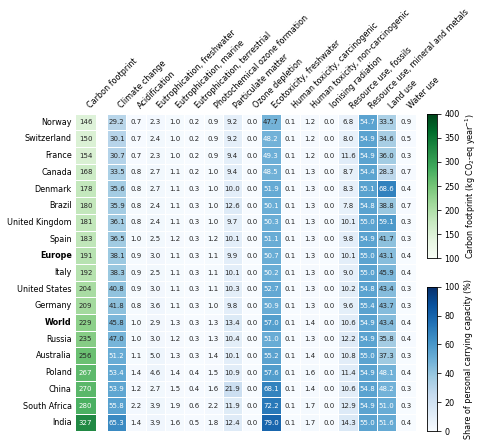

In [12]:
user = 'Medium technology user'
user_pb = EF_PB_medium
fig_name = 'fig_2.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

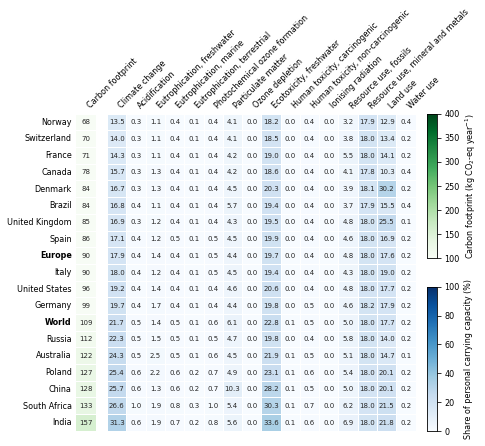

In [13]:
user = 'Low technology user'
user_pb = EF_PB_low
fig_name = 'SI_Results_low_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

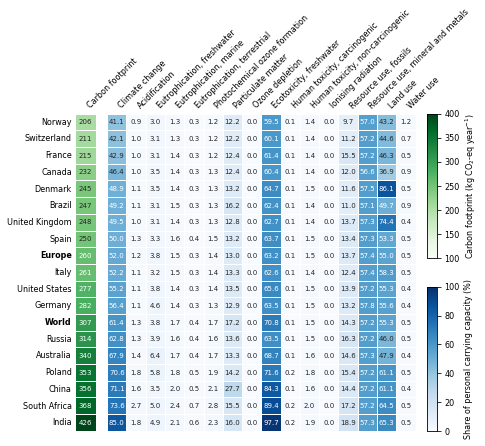

In [14]:
user = 'High technology user'
user_pb = EF_PB_high
fig_name = 'SI_Results_high_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

### Climate impacts under different carbon budgets

In [15]:
# Import carbon budgets for different targets and probabilities
CARBON_BUDGETS = pd.read_excel(Path(r"..\data\LCIA_EF30-Carrying-capacities.xlsx"), 'Carbon_budget_IPCC_Import', index_col=0)
CARBON_BUDGETS

,17%,33%,50%,67%,83%
Target,,,,,
1.5 °C,1126.268612,813.416220,625.704785,500.563828,375.422871
1.7 °C,1814.543875,1313.980048,1063.698134,875.986698,688.275263
2.0 °C,2878.242009,2127.396267,1689.402918,1439.121004,1126.268612


In [16]:
PB_CARBON_BUDGET_Current = dict()
for target in CARBON_BUDGETS.index:
    PB_CARBON_BUDGET_Current[target] = {}
    for prob in CARBON_BUDGETS.columns:
        PB_CARBON_BUDGET_Current[target][prob] = {}
        for loc in carbon_footprint_loc['Medium technology user']:
            PB_CARBON_BUDGET_Current[target][prob][loc] = carbon_footprint_loc['Medium technology user'][loc] * 100 / CARBON_BUDGETS.loc[target, prob]


In [17]:
pd.DataFrame(PB_CARBON_BUDGET_Current['2.0 °C']).sort_values('17%')

,17%,33%,50%,67%,83%
Norway,5.083175,6.877236,8.660223,10.166349,12.990335
Switzerland,5.227855,7.072981,8.906717,10.455711,13.360075
France,5.337887,7.221847,9.094178,10.675774,13.641266
Canada,5.833529,7.892421,9.938605,11.667058,14.907907
Denmark,6.199587,8.387676,10.562259,12.399173,15.843388
Brazil,6.242827,8.446178,10.635928,12.485655,15.953892
United Kingdom,6.282412,8.499734,10.703368,12.564824,16.055053
Spain,6.346124,8.585933,10.811916,12.692249,16.217873
Europe,6.630658,8.970890,11.296676,13.261315,16.945014
Italy,6.658525,9.008593,11.344154,13.317051,17.016232


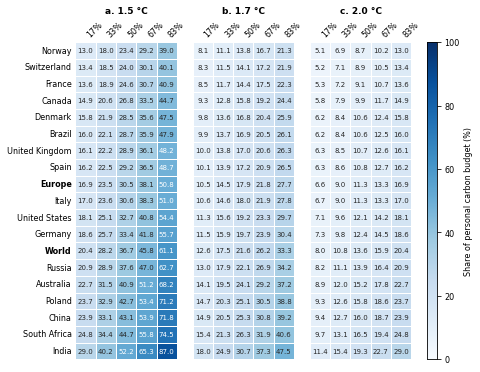

In [18]:
T_targets = list(CARBON_BUDGETS.index)

fig, axs = plt.subplot_mosaic([T_targets + ['cbar']],
                              figsize=(fig_length[2]*0.9, fig_height*0.6), 
                               gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

axs[T_targets[0]].set_title('a. ' + T_targets[0], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[1]].set_title('b. ' + T_targets[1], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[2]].set_title('c. ' + T_targets[2], fontweight='bold', loc='center', fontsize=fontsize_title)

for tt in T_targets:
    data_to_plot = pd.DataFrame(PB_CARBON_BUDGET_Current[tt]).sort_values('17%')
    sns.heatmap(ax=axs[tt], data=data_to_plot, cmap="Blues", vmin=0, vmax=100, 
                annot=True, fmt='.1f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['cbar'])
    axs[tt].xaxis.tick_top()
    axs[tt].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].set_xticklabels(list(data_to_plot.columns), rotation = 45, ha="left", fontsize=fontsize_axs)

for tt in T_targets[1:]:
    axs[tt].set_yticklabels('')
for lab, annot in zip(axs[T_targets[0]].get_yticklabels(), axs[T_targets[0]].texts):
    text = lab.get_text()
    if text in ['Europe', 'World']:
        lab.set_weight('bold')
        
for spine in axs['cbar'].spines.values():
    spine.set(visible=True, lw=spineline_width, edgecolor="black")
axs['cbar'].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
axs['cbar'].set_ylabel('Share of personal carbon budget (%)', fontsize=fontsize_label)

fig.subplots_adjust(wspace=0.2)
plt.savefig(Path(str(r"..\reports\submission") + '/SI_carbon_budget_sensitivity.jpg'), dpi=600, bbox_inches='tight')

## Monte Carlo simulation

Only for GLO location

In [19]:
GLO_user_ds = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
GLO_user_ds

'digital content consumption, medium technology user' (year, GLO, None)

Impact values

In [20]:
iterations = 1000
MonteCarlo_results_GLO = multi_lcia_MonteCarlo(GLO_user_ds, iterations, EF_METHODS)

In [21]:
MonteCarlo_stats_GLO = pd.DataFrame(MonteCarlo_results_GLO).describe()
MonteCarlo_stats_GLO.loc['CV'] = MonteCarlo_stats_GLO.loc['std'] * 100 / MonteCarlo_stats_GLO.loc['mean']
MonteCarlo_stats_GLO.T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max,CV
Climate change,2.758150e+02,2.740196e+01,201.703065,2.565586e+02,2.735938e+02,2.925718e+02,398.641132,9.934908
Acidification,1.690825e+00,1.655102e-01,1.261872,1.577143e+00,1.670805e+00,1.784150e+00,2.355956,9.788723
"Eutrophication, freshwater",3.356030e-02,1.452179e-02,0.012451,2.397096e-02,2.979348e-02,3.889256e-02,0.153478,43.270748
"Eutrophication, marine",4.091922e-01,4.375152e-02,0.287737,3.794065e-01,4.038748e-01,4.349551e-01,0.617050,10.692169
"Eutrophication, terrestrial",3.249828e+00,3.779954e-01,2.199282,2.995269e+00,3.203065e+00,3.464565e+00,4.823463,11.631244
Photochemical ozone formation,8.953200e-01,9.956967e-02,0.626339,8.301726e-01,8.821277e-01,9.488978e-01,1.331076,11.121127
Particulate matter,1.520569e-05,7.477391e-06,0.000006,1.055387e-05,1.300134e-05,1.705708e-05,0.000065,49.174955
Ozone depletion,2.025025e-05,5.636461e-06,0.000011,1.633467e-05,1.915488e-05,2.302470e-05,0.000057,27.834028
"Ecotoxicity, freshwater",1.345518e+04,2.587147e+03,7921.775159,1.169606e+04,1.308975e+04,1.490714e+04,25144.858705,19.227893
"Human toxicity, carcinogenic",2.792361e-07,3.209533e-07,-0.000002,8.356287e-08,2.765069e-07,4.682116e-07,0.000002,114.939785


Share of the personal carrying capacities

In [22]:
MonteCarlo_PB_GLO = dict()
for method in EF_METHODS:
    MonteCarlo_PB_GLO[method] = [i * 100 / EF_PB_LIMITS['EF3.0_2020'].to_dict()[method] for i in MonteCarlo_results_GLO[method]]

In [23]:
MonteCarlo_stats_PB_GLO = pd.DataFrame(MonteCarlo_PB_GLO).describe()
MonteCarlo_stats_PB_GLO.loc['CV'] = MonteCarlo_stats_PB_GLO.loc['std'] * 100 / MonteCarlo_stats_PB_GLO.loc['mean']
MonteCarlo_stats_PB_GLO.loc['deterministic'] = EF_PB_current['Medium technology user']['World']
MonteCarlo_stats_PB_GLO
MonteCarlo_stats_PB_GLO.T.drop('count', axis=1).round(2).astype(str) + '%'

,mean,std,min,25%,50%,75%,max,CV,deterministic
Climate change,55.1%,5.47%,40.3%,51.25%,54.66%,58.45%,79.64%,9.93%,45.83%
Acidification,1.32%,0.13%,0.98%,1.23%,1.3%,1.39%,1.84%,9.79%,1.04%
"Eutrophication, freshwater",4.53%,1.96%,1.68%,3.23%,4.02%,5.24%,20.7%,43.27%,2.92%
"Eutrophication, marine",1.58%,0.17%,1.11%,1.46%,1.56%,1.68%,2.38%,10.69%,1.28%
"Eutrophication, terrestrial",0.41%,0.05%,0.28%,0.38%,0.41%,0.44%,0.61%,11.63%,0.32%
Photochemical ozone formation,1.71%,0.19%,1.2%,1.59%,1.69%,1.82%,2.55%,11.12%,1.3%
Particulate matter,20.34%,10.0%,8.58%,14.12%,17.39%,22.81%,86.76%,49.17%,13.37%
Ozone depletion,0.03%,0.01%,0.02%,0.02%,0.03%,0.03%,0.08%,27.83%,0.02%
"Ecotoxicity, freshwater",80.91%,15.56%,47.63%,70.33%,78.71%,89.64%,151.2%,19.23%,56.97%
"Human toxicity, carcinogenic",0.2%,0.23%,-1.16%,0.06%,0.2%,0.34%,1.23%,114.94%,0.12%


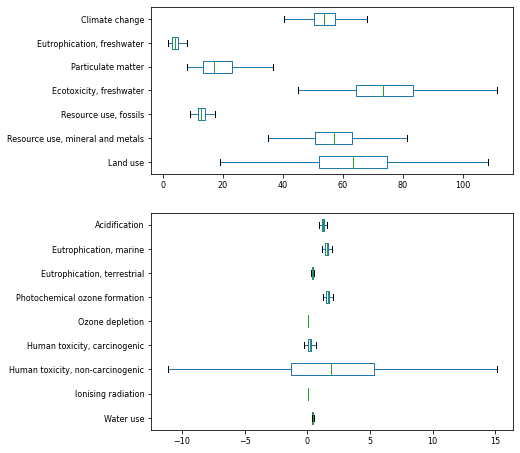

In [241]:
fig, axs = plt.subplot_mosaic([['Large_values'], ['Small_values']],
                              figsize=(fig_length[2]*0.9, fig_height*0.8), 
                              gridspec_kw={'height_ratios': [1, 1.3]})

data_to_plot = pd.DataFrame(MonteCarlo_results_GLO)

large_values_categories = ['Climate change', 'Eutrophication, freshwater', 'Particulate matter', 'Ecotoxicity, freshwater', 'Resource use, fossils', 'Resource use, mineral and metals', 'Land use']
small_values_categories = [i for i in list(EF_METHODS.keys()) if i not in large_values_categories]

data_to_plot[large_values_categories].boxplot(ax=axs['Large_values'], vert=False, fontsize=fontsize_axs, showfliers=False)
data_to_plot[small_values_categories].boxplot(ax=axs['Small_values'], vert=False, fontsize=fontsize_axs, showfliers=False)

for ax in ['Large_values', 'Small_values']:
    axs[ax].invert_yaxis()
    axs[ax].grid(False)


## Contribution analysis by system component

In [24]:
locations_CA = ['NO', 'GLO', 'IN']

In [25]:
CA_system_medium_CH_GLO_IN = {}
for loc in locations_CA:
    activity = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == loc][0]
    system_contributions = internet_system_contributions(activity, EF_METHODS, activity_amount=1)
    CA_system_medium_CH_GLO_IN[loc] = system_contributions

In [39]:
CA_system_absolute = pd.DataFrame(CA_system_medium_CH_GLO_IN['IN'])
CA_system_relative = (CA_system_absolute.T * 100 / CA_system_absolute.T.sum()).T
CA_system_relative

,End-user devices | operation,End-user devices | embodied,CPE | operation,CPE | embodied,Access network,Core network,Data centres | operation,Data centres | embodied
Climate change,32.767368,22.699719,10.633815,0.153573,4.253526,12.072389,17.101765,0.317846
Acidification,29.587168,30.188716,9.601762,0.289563,3.840705,10.797748,15.221298,0.473041
"Eutrophication, freshwater",23.620516,37.979349,7.665437,0.344389,3.066175,8.554970,18.251723,0.517441
"Eutrophication, marine",22.486529,37.835714,7.297430,0.166274,2.918972,8.029794,20.955068,0.310219
"Eutrophication, terrestrial",31.002829,28.852604,10.061179,0.232649,4.024471,10.939910,14.467454,0.418905
Photochemical ozone formation,30.240608,30.114870,9.813819,0.236018,3.925527,10.815660,14.385605,0.467893
Particulate matter,16.173435,44.680073,5.248676,0.316580,2.099470,8.514379,22.295698,0.671687
Ozone depletion,7.041644,63.665303,2.285186,0.376803,0.914074,5.777479,19.222613,0.716897
"Ecotoxicity, freshwater",23.910751,41.394493,7.759625,0.546503,3.103850,7.928189,14.571048,0.785541
"Human toxicity, carcinogenic",15.934730,55.520286,5.171211,0.519433,2.068484,6.105512,13.630676,1.049667


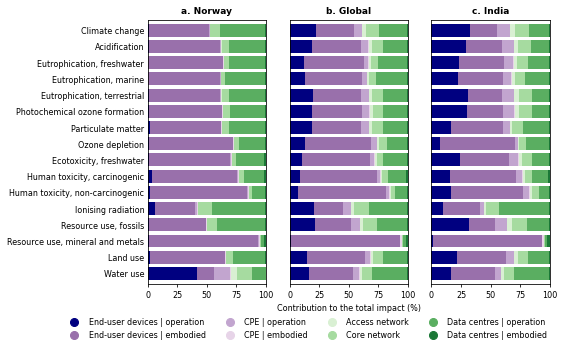

In [29]:
width=0.8
#system_color = ['#762a83', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']
system_color = ['#b35806', '#e08214', '#fdb863', '#fee0b6', '#d8daeb', '#b2abd2', '#8073ac', '#542788']
system_color = ['navy', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']
fig, axs = plt.subplots(1, 3, figsize=(fig_length[2], fig_height*0.5), sharey=True)

count_ax = 0
for loc in locations_CA:
    ds_plot = pd.DataFrame(CA_system_medium_CH_GLO_IN[loc])
    ds_plot = (ds_plot.T * 100 / ds_plot.T.sum()).T
    
    ds_plot.plot.barh(ax=axs[count_ax], stacked=True, width=width, fontsize=fontsize_axs, lw=spineline_width, color=system_color, legend=False, zorder=2)
    axs[count_ax].invert_yaxis()
    
    axs[count_ax].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[count_ax].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
    
    axs[count_ax].set_xlim(0, 100)
    
    count_ax += 1

axs[1].set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

axs[0].set_title('a. Norway', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[1].set_title('b. Global', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[2].set_title('c. India', fontweight='bold', loc='center', fontsize=fontsize_title)

patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
              bbox_to_anchor=(2.24,-0.1), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/fig_3.jpg'), dpi=600, bbox_inches='tight')

## Contribution analysis of embodied and operational impacts of end-user devices

Only for the GLO average user

In [30]:
user_devices_embodied_lcia = user_devices_embodied_impacts(GLO_user_ds, EF_METHODS, activity_amount=1)
user_devices_operational_lcia = user_devices_operational_impacts(GLO_user_ds, EF_METHODS, activity_amount=1)

In [31]:
user_devices_embodied_lcia_df = pd.DataFrame(user_devices_embodied_lcia)
user_devices_operational_lcia_df = pd.DataFrame(user_devices_operational_lcia)

In [32]:
user_devices_embodied_total_share = (user_devices_embodied_lcia_df.T * 100 / user_devices_embodied_lcia_df.T.sum()).T
user_devices_embodied_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,14.684755,15.938573,20.978348,37.992854,10.405470
Acidification,10.821564,11.789254,19.296083,38.684836,19.408263
"Eutrophication, freshwater",17.612442,19.180786,18.991278,33.137736,11.077759
"Eutrophication, marine",8.444766,9.577513,16.315163,57.653563,8.008995
"Eutrophication, terrestrial",10.539452,11.523356,19.723803,43.314413,14.898975
Photochemical ozone formation,11.140394,11.835925,18.632282,40.037610,18.353789
Particulate matter,10.308578,11.375474,23.375572,38.725426,16.214951
Ozone depletion,22.951035,25.244854,16.508979,27.796528,7.498604
"Ecotoxicity, freshwater",6.295303,6.696839,20.892493,42.360262,23.755103
"Human toxicity, carcinogenic",11.376281,11.921286,19.468264,38.336518,18.897651


In [40]:
user_devices_operational_total_share = (user_devices_operational_lcia_df.T * 100 / user_devices_operational_lcia_df.T.sum()).T
user_devices_operational_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,3.658307,2.873907,18.431338,66.248666,8.787783
Acidification,3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, marine",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, terrestrial",3.658307,2.873907,18.431338,66.248666,8.787783
Photochemical ozone formation,3.658307,2.873907,18.431338,66.248666,8.787783
Particulate matter,3.658307,2.873907,18.431338,66.248666,8.787783
Ozone depletion,3.658307,2.873907,18.431338,66.248666,8.787783
"Ecotoxicity, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Human toxicity, carcinogenic",3.658307,2.873907,18.431338,66.248666,8.787783


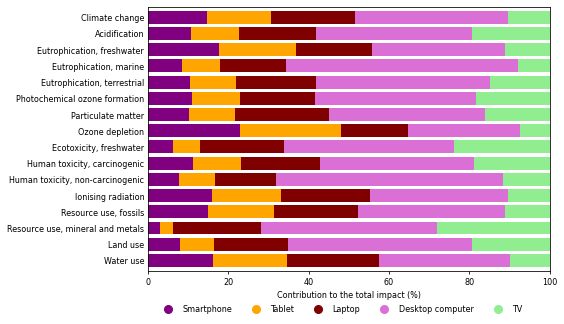

In [34]:
width=0.8
content_color = ['purple', 'orange', 'maroon', 'orchid', 'lightgreen']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.5))
    
user_devices_embodied_total_share.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=END_USER_DEVICES[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=END_USER_DEVICES[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=END_USER_DEVICES[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=END_USER_DEVICES[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=END_USER_DEVICES[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
              bbox_to_anchor=(0.95,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_emboided_impacts_devices.jpg'), dpi=600, bbox_inches='tight')

## Contribution analysis by digital content

Only for the GLO user

In [35]:
CA_content_medium_GLO = digital_content_constributions(GLO_user_ds, EF_METHODS, DIGITAL_CONTENT, activity_amount=1)

In [36]:
CA_content_absolute = pd.DataFrame(CA_content_medium_GLO)
CA_content_relative = (CA_content_absolute.T * 100 / CA_content_absolute.T.sum()).T
CA_content_relative

,Web surfing,Social media,Video streaming,Music streaming,Video conferencing
Climate change,14.902597,15.094173,47.342430,11.149760,11.511039
Acidification,14.825055,14.187834,48.099994,11.165141,11.721975
"Eutrophication, freshwater",15.873401,15.456303,46.204121,11.766535,10.699641
"Eutrophication, marine",14.843674,14.137751,46.071557,11.661398,13.285620
"Eutrophication, terrestrial",15.182814,14.359847,46.699924,11.515820,12.241595
Photochemical ozone formation,14.972453,14.269764,47.546726,11.349846,11.861211
Particulate matter,15.344428,14.214078,47.002360,11.362439,12.076695
Ozone depletion,17.733636,16.901737,41.878804,13.323447,10.162376
"Ecotoxicity, freshwater",14.563029,12.527471,49.687619,10.838698,12.383183
"Human toxicity, carcinogenic",16.103560,13.737008,46.137753,12.066047,11.955633


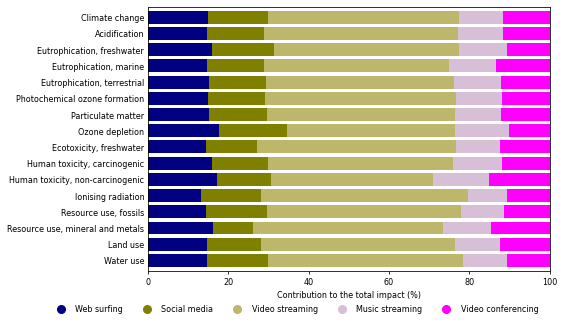

In [37]:
width=0.8
content_color = ['navy', 'olive', 'darkkhaki', 'thistle', 'fuchsia']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.5))
    
CA_content_relative.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=DIGITAL_CONTENT[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=DIGITAL_CONTENT[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=DIGITAL_CONTENT[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=DIGITAL_CONTENT[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=DIGITAL_CONTENT[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
               bbox_to_anchor=(0.99,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_impacts_by_digital_content.jpg'), dpi=600, bbox_inches='tight')

# Prospective analysis

## Only background inventories prospective

In [41]:
EF_LCIA_2030 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2030'], EF_METHODS)
EF_LCIA_2040 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2040'], EF_METHODS)
EF_LCIA_2050 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2050'], EF_METHODS)

In [42]:
EF_PB_2030 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2030, EF_PB_LIMITS['EF3.0_2030'])
EF_PB_2040 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2040, EF_PB_LIMITS['EF3.0_2040'])
EF_PB_2050 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2050, EF_PB_LIMITS['EF3.0_2050'])

In [43]:
CA_system_medium_prospective = {}
EF_METHODS_PROSPECTIVE = {impact: EF_METHODS[impact] for impact in ['Climate change', 'Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']}

for db in [DBS['Digital content 2030'], DBS['Digital content 2040'], DBS['Digital content 2050']]:
    CA_system_medium_prospective[db] = {}
    activity = [ds for ds in bw.Database(db) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
    CA_system_medium_prospective[db] = internet_system_contributions(activity, EF_METHODS_PROSPECTIVE, activity_amount=1)

In [45]:
CA_system_medium_timeserie = {}
CA_system_medium_PB_timeserie = {}
for impact in EF_METHODS_PROSPECTIVE:
    CA_system_medium_timeserie[impact] = {}
    
    CA_system_medium_PB_timeserie[impact] = {}
    CA_system_medium_PB_timeserie[impact]['Current'] = EF_PB_current['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2030'] = EF_PB_2030['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2040'] = EF_PB_2040['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2050'] = EF_PB_2050['Medium technology user']['World'][impact]
    
    for system in INTERNET_COMPONENTS:
        CA_system_medium_timeserie[impact][system] = {}
        CA_system_medium_timeserie[impact][system]['Current'] = CA_system_medium_CH_GLO_IN['GLO'][system][impact]
        CA_system_medium_timeserie[impact][system]['2030'] = CA_system_medium_prospective[DBS['Digital content 2030']][system][impact]
        CA_system_medium_timeserie[impact][system]['2040'] = CA_system_medium_prospective[DBS['Digital content 2040']][system][impact]
        CA_system_medium_timeserie[impact][system]['2050'] = CA_system_medium_prospective[DBS['Digital content 2050']][system][impact]

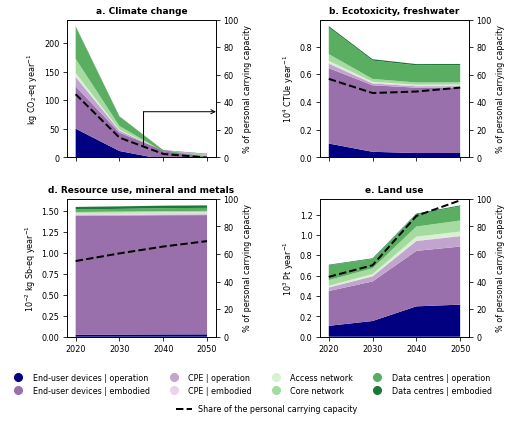

In [46]:
prospective_categories = ['Climate change', 'Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']
categories_titles = ['a. Climate change', 'b. Ecotoxicity, freshwater',
                     'd. Resource use, mineral and metals', 'e. Land use']
categories_units = ['kg CO$_2$-eq year$^{-1}$', '10$^{4}$ CTUe year$^{-1}$',
                    '10$^{-2}$ kg Sb-eq year$^{-1}$', '10$^{3}$ Pt year$^{-1}$']
multiply_values = [1, 1e-4, 1e2, 1e-3]

fig, axs = plt.subplots(2, 2, figsize=(fig_length[2], fig_height*0.6), sharex=True)

counter=0
for row in range(2):
    for col in range(2):
        axs[row,col].set_title(categories_titles[counter], fontweight='bold', loc='center', fontsize=fontsize_title)
        axs[row,col].set_ylabel(categories_units[counter], fontsize=fontsize_label) 
        
        data_to_plot = [list(CA_system_medium_timeserie[prospective_categories[counter]][i].values()) for i in CA_system_medium_timeserie[prospective_categories[counter]]]
        data_to_plot = [[j*multiply_values[counter] for j in i] for i in data_to_plot]
        
        axs[row,col].stackplot([2020, 2030, 2040, 2050], data_to_plot, labels=INTERNET_COMPONENTS, colors=system_color, zorder=3)
        axs[row,col].set_ylim(ymin=0)
        
        axs1 = axs[row,col].twinx()
        axs1.plot([2020, 2030, 2040, 2050], list(CA_system_medium_PB_timeserie[prospective_categories[counter]].values()),
                  color='black', lw=2, ls='--')
        axs1.set_ylim(0,100)
        axs1.tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs1.set_ylabel('% of personal carrying capacity', fontsize=fontsize_label) 
        
        axs[row,col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs[row,col].yaxis.offsetText.set_fontsize(fontsize_axs)
        axs[row,col].set_xticks([2020, 2030, 2040, 2050], )
        axs[row,col].set_xlim(2018,2052)
    #    axs[row,col].grid(ls='--', lw=0.5, zorder=0)
        counter += 1 
        
axs[0,0].axhline(y=0, ls='-', color='black', lw=0.8)
axs[0,0].annotate(text='', xy=(2035,80), xytext=(2052.5,80), arrowprops=dict(arrowstyle='<-'))
axs[0,0].annotate(text='', xy=(2035.5,18), xytext=(2035.5,83), arrowprops=dict(arrowstyle='-'))

# LEGEND
patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1,1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
                bbox_to_anchor=(1.2,-0.21), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

line = Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Share of the personal carrying capacity')
axs[1,0].legend(handles=[line], bbox_to_anchor=(2,-0.44), frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

fig.subplots_adjust(wspace=0.7, hspace=0.3)
plt.savefig(Path(str(r"..\reports\submission") + '/fig_4.jpg'), dpi=600, bbox_inches='tight')

In [47]:
impacts_2020_vs_2050 = pd.concat([pd.DataFrame(EF_LCIA_current['Medium technology user'])[['World']], pd.DataFrame(EF_LCIA_2050['Medium technology user'])], axis=1)
impacts_2020_vs_2050.columns = ['Current', 'P_2050']
impacts_2020_vs_2050['Diff'] = (impacts_2020_vs_2050.P_2050 - impacts_2020_vs_2050.Current) / impacts_2020_vs_2050.Current * 100
impacts_2020_vs_2050

,Current,P_2050,Diff
Climate change,2.294244e+02,-7.278232e-01,-100.317239
Acidification,1.332966e+00,4.542934e-01,-65.918613
"Eutrophication, freshwater",2.165919e-02,1.107372e-02,-48.872884
"Eutrophication, marine",3.321034e-01,1.940499e-01,-41.569426
"Eutrophication, terrestrial",2.497941e+00,1.073347e+00,-57.030723
Photochemical ozone formation,6.796243e-01,3.059876e-01,-54.976939
Particulate matter,9.997869e-06,4.575674e-06,-54.233513
Ozone depletion,1.276754e-05,1.195572e-05,-6.358483
"Ecotoxicity, freshwater",9.475076e+03,6.745122e+03,-28.811946
"Human toxicity, carcinogenic",1.647883e-07,1.386081e-07,-15.887161


In [48]:
pd.DataFrame(EF_PB_2050['Medium technology user']['World'], index=['value']).T

,value
Climate change,-0.145401
Acidification,0.442256
"Eutrophication, freshwater",1.865105
"Eutrophication, marine",0.935189
"Eutrophication, terrestrial",0.170458
Photochemical ozone formation,0.731892
Particulate matter,6.119963
Ozone depletion,0.021554
"Ecotoxicity, freshwater",50.655081
"Human toxicity, carcinogenic",0.099625


## Background + foreground inventories prospective with presamples

In [50]:
import presamples as ps

In [51]:
sensitivity_analysis_data = Path(r"..\data\Data_for_sensitivity_analysis_with_presamples.xlsx")

In [52]:
def read_presamples_scenario_data(scenario_file, Ecoinvent_db, Other_db):
    """
    This function reads the scenario data from an excel file and prepares it into a dataframe for being used with Presamples.
    Secondly, it adds the bw codes for the involved activities.
    The dictionary map_bw_keys provides these codes, it needs to be generated beforehand with the involved databases.    
    """

    # Create mapping of BW codes for involved databases
    map_bw_keys = dict()
    for db in [Ecoinvent_db, Other_db]:
        db_obj = bw.Database(db)
        for ds in db_obj:
            map_bw_keys[(ds['reference product'], ds['name'], ds['location'])] = ds.key
    
    scenariodata_df = pd.read_excel(scenario_file) # Import data
    scenariodata_df = scenariodata_df.dropna(how="all") # Delete empty rows
    
    scenario_label = list(scenariodata_df.columns)[9:] # Get label of scenarios
    
    # add the bw code to your scenario DF (input = process, output = to_process)
    scenariodata_df["input"] = [map_bw_keys[(row["from_reference_product"], row["from_process"], row["from_location"])] 
                                for index, row in scenariodata_df.iterrows()]
    scenariodata_df["output"] = [map_bw_keys[(row["to_reference product"], row["to_process"], row["to_location"])] 
                                 for index, row in scenariodata_df.iterrows()]

    return scenario_label, scenariodata_df

In [53]:
def make_pspackage(scenariodata_df, scenario_label, matrixlabel, ps_packagename):
    """
    This function prepares a Presamples package out of the scenario data if.
    """
        
    # select needed data
    samples = scenariodata_df[scenario_label].values
    indices = [(row['input'], row['output'], row['from_type']) for i, row in scenariodata_df.iterrows()] 

    # Generate PS data in PSpackage
    data = [(samples, indices, matrixlabel)]
    
    ps_id, ps_filepath = ps.create_presamples_package(matrix_data=data, name=ps_packagename, seed="sequential") 
    
    print("\n ps_id, filepath:", ps_id, ps_filepath)
    
    return samples, indices, ps_filepath

In [54]:
# Read the excel file to get the scenario data
scenario_label, scenariodata_df = read_presamples_scenario_data(sensitivity_analysis_data, DBS['Ecoinvent 2050'], DBS['Digital content 2050'])
scenariodata_df.head()

,to_reference product,to_process,to_location,to_database,from_reference_product,from_process,from_location,from_type,from_database,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime,input,output
0,"costumer premise equipment, internet access","costumer premise equipment, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.007000,0.003818,0.003818,0.003818,0.003818,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
1,"access network, internet access","access network, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.002800,0.001527,0.001527,0.001527,0.001527,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
2,"core network, internet access, access network ...","core network, internet access, access network ...",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.008858,0.004832,0.004832,0.004832,0.004832,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
3,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RNA,technosphere,ecoinvent,0.003440,0.001876,0.001876,0.001876,0.001876,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
4,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RAS,technosphere,ecoinvent,0.003031,0.001653,0.001653,0.001653,0.001653,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."


In [55]:
# Create PS package with indices + samples matrix
samples_v1, indices_v1, ps_filepath_v1 =  make_pspackage(scenariodata_df, scenario_label, "technosphere", "ps_v1")


 ps_id, filepath: 76b3c41d13e64a12b55e9304214789dc C:\Users\iistrate\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\76b3c41d13e64a12b55e9304214789dc


In [56]:
activity_for_ps = [ds for ds in bw.Database(DBS['Digital content 2050']) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
activity_for_ps_lca = bw.LCA({activity_for_ps:1}, presamples=[ps_filepath_v1])

sensitivity_analysis_lcia = dict()
for impact in EF_METHODS:
    sensitivity_analysis_lcia[impact] = {}

scenario_lcia = dict()
for i in range(len(scenario_label)): # Scenarios
    if i == 0: # Don't update the first time around, since indexer already at 0th column
        activity_for_ps_lca.lci() # Builds matrices
        multi_lcia_results = dict()
        for impact in EF_METHODS:
            activity_for_ps_lca.switch_method(EF_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
    else:
        activity_for_ps_lca.presamples.update_matrices() # Move to next column and update matrices
        activity_for_ps_lca.redo_lci()
        multi_lcia_results = dict()
        for impact in EF_METHODS:
            activity_for_ps_lca.switch_method(EF_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
                
    scenario_lcia[scenario_label[i]] = multi_lcia_results

    for impact in EF_METHODS:
        sensitivity_analysis_lcia[impact][scenario_label[i]] = scenario_lcia[scenario_label[i]][impact]

In [63]:
sensitivity_analysis_lcia_df = pd.DataFrame(sensitivity_analysis_lcia).T
sensitivity_analysis_lcia_df

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,-7.086136e-01,7.068063e+00,4.456189e+00,2.720963e+00,5.519311e-01
Acidification,4.545088e-01,3.856954e-01,3.228968e-01,2.815700e-01,2.299117e-01
"Eutrophication, freshwater",1.107907e-02,1.072392e-02,9.042123e-03,7.919863e-03,6.517038e-03
"Eutrophication, marine",1.940864e-01,1.794320e-01,1.552881e-01,1.391447e-01,1.189655e-01
"Eutrophication, terrestrial",1.073796e+00,8.660421e-01,7.378811e-01,6.526039e-01,5.460074e-01
Photochemical ozone formation,3.061228e-01,2.465670e-01,2.092177e-01,1.843915e-01,1.533588e-01
Particulate matter,4.578306e-06,3.761338e-06,3.200656e-06,2.827881e-06,2.361913e-06
Ozone depletion,1.195940e-05,9.465772e-06,8.048329e-06,7.101948e-06,5.918972e-06
"Ecotoxicity, freshwater",6.749196e+03,6.231572e+03,5.250466e+03,4.599965e+03,3.786838e+03
"Human toxicity, carcinogenic",1.386717e-07,1.233210e-07,1.030191e-07,8.963640e-08,7.290796e-08


In [64]:
sensitivity_analysis_lcia_PB = sensitivity_analysis_lcia_df.divide(EF_PB_LIMITS['EF3.0_2050'], axis=0).multiply(100)
sensitivity_analysis_lcia_PB

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,-0.141563,1.412020,0.890234,0.543580,0.110262
Acidification,0.442466,0.375476,0.314341,0.274109,0.223820
"Eutrophication, freshwater",1.866005,1.806190,1.522930,1.333912,1.097640
"Eutrophication, marine",0.935365,0.864741,0.748383,0.670583,0.573333
"Eutrophication, terrestrial",0.170529,0.137536,0.117183,0.103640,0.086711
Photochemical ozone formation,0.732215,0.589764,0.500428,0.441046,0.366819
Particulate matter,6.123484,5.030790,4.280877,3.782291,3.159059
Ozone depletion,0.021560,0.017065,0.014509,0.012803,0.010671
"Ecotoxicity, freshwater",50.685677,46.798382,39.430388,34.545197,28.438708
"Human toxicity, carcinogenic",0.099670,0.088637,0.074045,0.064426,0.052403


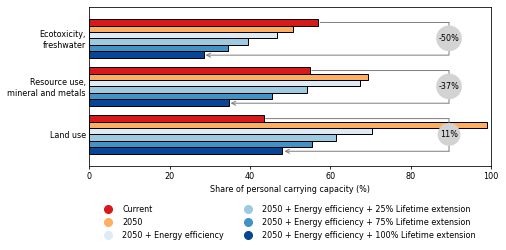

In [65]:
width=0.8

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.3))

sensitivity_color = ['#d7191c', '#fdae61', '#deebf7', '#9ecae1', '#4292c6', '#084594']
df_to_plot = sensitivity_analysis_lcia_PB.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']].T
#df_to_plot.drop(['default'], axis=0, inplace=True)
#df_to_plot = pd.concat([pd.DataFrame(EF_PB_2050['Medium technology user']['World'], ['default']).T.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']].T, df_to_plot])
df_to_plot = pd.concat([pd.DataFrame(EF_PB_medium.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']]['World']).T, df_to_plot])
df_to_plot.T.plot.barh(ax=axs, fontsize=fontsize_axs, color=sensitivity_color, width=width, edgecolor='black', legend=False, zorder=2)

axs.invert_yaxis()
axs.set_xlim(0, 100)

axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)

#axs.grid(ls='--', lw=0.5, zorder=0)
axs.set_xlabel('Share of personal carrying capacity (%)', fontsize=fontsize_label)

labels = [item.get_text() for item in axs.get_yticklabels()]
labels[0] = 'Ecotoxicity,\nfreshwater'
labels[1] = 'Resource use,\nmineral and metals'
axs.set_yticklabels(labels)


axs.annotate(text='', xy=(df_to_plot.loc['World']['Ecotoxicity, freshwater'], -0.33), xytext=(90,-0.33), arrowprops=dict(arrowstyle='-', color='grey'))
axs.annotate(text='', xy=(df_to_plot.loc['World']['Resource use, mineral and metals'], 0.67), xytext=(90,0.67), arrowprops=dict(arrowstyle='-', color='grey'))
axs.annotate(text='', xy=(df_to_plot.loc['World']['Land use'], 1.67), xytext=(90,1.67), arrowprops=dict(arrowstyle='-', color='grey'))

axs.annotate(text='', xy=(df_to_plot.loc['energy_efficiency_100%_lifetime']['Ecotoxicity, freshwater'], 0.35), xytext=(90,0.35), arrowprops=dict(arrowstyle='->', color='grey'))
axs.annotate(text='', xy=(df_to_plot.loc['energy_efficiency_100%_lifetime']['Resource use, mineral and metals'], 1.35), xytext=(90,1.35), arrowprops=dict(arrowstyle='->', color='grey'))
axs.annotate(text='', xy=(df_to_plot.loc['energy_efficiency_100%_lifetime']['Land use'], 2.35), xytext=(90,2.35), arrowprops=dict(arrowstyle='->', color='grey'))

axs.annotate(text='', xy=(89.5, -0.37), xytext=(89.5,0.38), arrowprops=dict(arrowstyle='-', color='grey'), va='center')
axs.annotate(text='', xy=(89.5, 0.63), xytext=(89.5,1.39), arrowprops=dict(arrowstyle='-', color='grey')) 
axs.annotate(text='', xy=(89.5, 1.63), xytext=(89.5,2.39), arrowprops=dict(arrowstyle='-', color='grey'))   

percentage_reduction = (df_to_plot.loc['energy_efficiency_100%_lifetime'] - df_to_plot.loc['World']) * 100 / df_to_plot.loc['World']
axs.text(89.5, 0, str(round(percentage_reduction['Ecotoxicity, freshwater'])) + '%', ha="center", va="center", rotation=0, size=fontsize_axs, bbox=dict(boxstyle="circle,pad=0.3", fc="lightgrey", ec="None", lw=2))
axs.text(89.5, 1, str(round(percentage_reduction['Resource use, mineral and metals'])) + '%', ha="center", va="center", rotation=0, size=fontsize_axs, bbox=dict(boxstyle="circle,pad=0.3", fc="lightgrey", ec="None", lw=2))
axs.text(89.5, 2, str(round(percentage_reduction['Land use'])) + '%', ha="center", va="center", rotation=0, size=fontsize_axs, bbox=dict(boxstyle="circle,pad=0.3", fc="lightgrey", ec="None", lw=2))
 

# LEGEND
patch_0 = Line2D([0], [0], color=sensitivity_color[0], label='Current', ls='None', marker='o', ms=8)
patch_1 = Line2D([0], [0], color=sensitivity_color[1], label='2050', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=sensitivity_color[2], label='2050 + Energy efficiency', ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=sensitivity_color[3], label='2050 + Energy efficiency + 25% Lifetime extension', ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=sensitivity_color[4], label='2050 + Energy efficiency + 75% Lifetime extension', ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=sensitivity_color[5], label='2050 + Energy efficiency + 100% Lifetime extension', ls='None', marker='o', ms=8)

axs.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4, patch_5], 
                bbox_to_anchor=(0.98,-0.2), ncol=2, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/fig_5.jpg'), dpi=600, bbox_inches='tight')